## Schrodinger Equation ##

We are going to solve the Schrodinger equation on a domain $\Omega_h$ with Dirichlet boundary contitions.

The equation to solve is:

$$
i \frac{\partial u}{\partial t} = \Delta u 
$$

Which we solve using,

$$
i (u - u_n) = dt *  \Delta (u + u_n)/2
$$

As time integrator, here $u = u_{n+1}$. Since the eigenvalues of $\Delta$ are proportional to $\Delta x^2$, $\lambda = -c/\Delta x^2$, $c > 0$, we must be carefull with the stability region of the method. We have, for each eigenfunction, 

$$
(i - \lambda dt/2)u = (i + \lambda dt /2 )u_n
$$

Thus, the amplification factor is: 

$$
|\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2}| = 1
$$

and the system is unconditionaly stable.



We shall use its weak form,

$$
\int [2i v*u +  \nabla v \cdot \nabla u ] \; d\Omega = \int [2i*v*u_n - \nabla v \cdot \nabla u_n ] \; d\Omega
$$



In [2]:
import Pkg;
Pkg.activate("gridap_makie");
using Gridap
using GridapMakie, GLMakie
using FileIO
#using Plots
#mkdir("models")
#mkdir("images")
using GridapGmsh
#using GridapGeosciences
using Gridap.Arrays
#using Gridap.TensorValues
using Gridap.ReferenceFEs
#using Gridap.Geometry
#using Gridap.Fields
using Gridap.Algebra
using SparseArrays
using Gridap.FESpaces
using Gridap.CellData

  Activating project at `~/Docencia/PDE/pde/2022/Numéricos/Tarea_7/gridap_makie`


In [52]:
l = 180
domain = (0, 1, 0, 1)
partition = (l, l)
model = CartesianDiscreteModel(domain, partition)
# dynamic viscosity

test = false
bump = false
particle = false

#particle = true
test = true

save_file::String = "Results/QM/"

if test
    T = 1 / π
    num_steps = 1000
    n_int = 100
    save_file = save_file * "test" #where to save things
elseif bump
    save_file = save_file * "bump"
    T = 4
    num_steps = 1601
    n_int = 160
elseif particle
    save_file = save_file * "particle"
    T = 3           # final time for test

    num_steps = 1601   # number of time steps for 128 T=3 
    #num_steps = 12000   # number of time steps for 128 T=6 
    #num_steps = 10000   # number of time steps for 64 T=3 
    #num_steps = 50000   # number of time steps for 64 T=6 
        # Intervals where data is saved
    n_int = 160 # for 64
    #mod = 60 # for 128
    #mod = 120 # for 128 T=6
    #mod = 240 # for 256 T=3
    #mod = 480
end

dt = T / (num_steps - 1)

println("dt / dx^2 = $(dt * l^2)   dt / dx = $(dt * l)  dt^3 / dx^6 = $((dt * l^2)^3)")

dt / dx^2 = 10.323563876231049   dt / dx = 0.057353132645728055  dt^3 / dx^6 = 1100.2438453905734


The first number indicates what it would be the CFL condition for the explicit Euler method. The second a guide about taking time and space comparable steps. The third is proportinal to the error, obtained by expanding 

$$
\frac{1 + i\lambda dt /2}{1 - i\lambda dt /2} - e^{i\lambda dt} = (1 + i\lambda dt /2)(1 + i\lambda dt /2 - \frac{\lambda^2 dt^2}{4})  - (1 + i\lambda dt - \frac{\lambda^2 dt^2}{2}) = O(\lambda dt)^3 
$$

In [41]:
labels = get_face_labeling(model)
add_tag_from_tags!(labels, "diri_all", [1, 2, 3, 4, 5, 6, 7, 8]);

In [42]:
order = 2
degree = order
Ωₕ = Triangulation(model)
dΩₕ = Measure(Ωₕ, degree)


Measure()

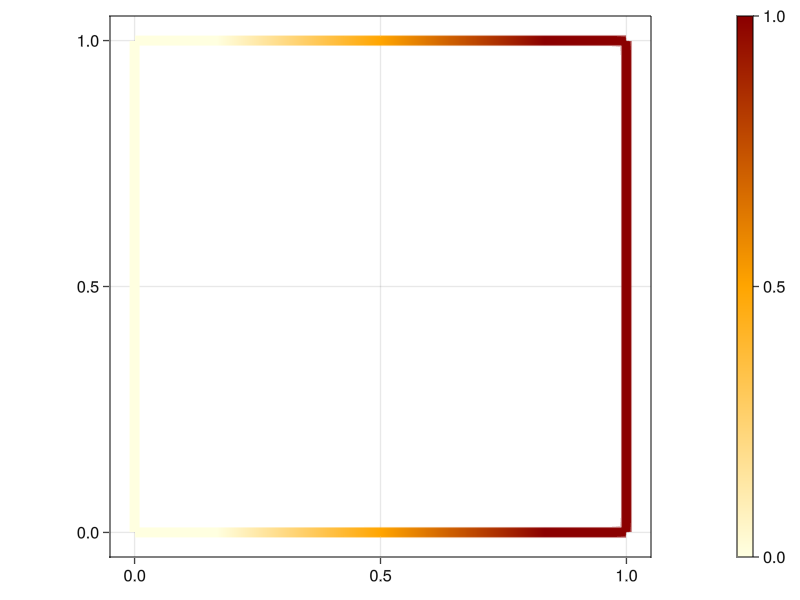

In [43]:
ue(x) = x[1]
Γ₁ = BoundaryTriangulation(model, tags=[5, 6, 7, 8])
fig, ax, plt = plot(Γ₁, ue, colormap=:heat, linewidth=10)
ax.aspect = AxisAspect(1)
Colorbar(fig[1, 2], plt)
fig

#plot(Γ₁)

In [ ]:
#scatter(BoundaryTriangulation(model,tags=[4]))


In [57]:
reffe = ReferenceFE(lagrangian, Float64, order)

(Lagrangian(), (Float64, 2), Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}())

In [58]:
V = TestFESpace(model, reffe, labels=labels, dirichlet_tags=["diri_all"], conformity=:H1, vector_type=Vector{ComplexF64})
U = TrialFESpace(V, 0.0)

TrialFESpace()

In [ ]:
#ls = LUSolver()
#solver = LinearFESolver(ls)

In [46]:
norm_L2(u) = sqrt(real(sum(∫(u' * u) * dΩₕ)))

norm_L2 (generic function with 1 method)

In [47]:
function u_0_bump(x, par)
    r0, r1, p = par
    r = sqrt((x[1] - 0.5)^2 + (x[2] - 0.5)^2)
    if r > r0 && r < r1
        return (r - r0)^p * (r - r1)^p * (4^(2p)) + 0.0 * im
    else
        return 0.0 + 0.0 * im
    end
end

function u_0_particle(x, par)
    r0, xi, k, p = par
    r = sqrt((x[1] - xi[1])^2 + (x[2] - xi[2])^2)
    kx = 2π * (k[1] * (x[1] - xi[1]) + k[2] * (x[2] - xi[2]))
    if r < r0
        return (r - r0)^p * (r - r0)^p * (4^(2p)) * exp(im * kx)
    else
        return 0.0 + 0.0 * im
    end
end



function u_0_test(x, p)
    n, m = p
    return sin(π * x[1] * n) * sin(π * x[2] * m)
end

function test_solution(x, t, p)
    n, m = p
    ω = π^2 * (n^2 + m^2)
    return sin(π * x[1] * n) * sin(π * x[2] * m) * exp(im * ω * t)
end

par_bump = (0.25, 0.75, 4)
par_test = (2, 3)
par_particle = (0.4, [0.25; 0.25], [-16; 16], 4)

#u_0_bump([0.5;0.5], par_bump)
u_0_test([0.8; 0.5], par_test)
#u_0_particle([0.5;0.5], par_particle)


0.9510565162951536

In [48]:
if test
    u_0(x) = u_0_test(x, par_test)
elseif bump
    u_0(x) = u_0_bump(x, par_bump)
elseif particle
    u_0(x) = u_0_particle(x, par_particle)
end

u_n = interpolate_everywhere(u_0, V)
writevtk( Ωₕ,"Results/QM/ini_dat_$(lpad(0,3,'0'))", cellfields=["uh_r"=>real(u_n),"uh_i"=>imag(u_n)])

norm_L2(u_n)
#sum(∫(u_n'*u_n)*dΩₕ)

0.49999999218761737

In [49]:
fig, axₕlt = plot(Ωₕ, real(u_n))
ax.aspect = AxisAspect(1)
Colorbar(fig[2, 1], plt, vertical=false)
current_figure()
#fig

To generate just once the matrix A we follow this example: https://github.com/gridap/Gridap.jl/blob/master/test/FESpacesTests/AssemblersTests.jl



In [53]:
assem = SparseMatrixAssembler(U, V)
dv = get_fe_basis(V)
du = get_trial_fe_basis(U)

a(u, v) = ∫(∇(v) ⋅ ∇(u) * dt + im * 2 * v * u)dΩₕ

mat_contribs = a(du, dv)
data = collect_cell_matrix(U, V, mat_contribs)
A = assemble_matrix(assem, data)

t = 0
u_n = interpolate_everywhere(u_0, V)
writevtk(
  Ωₕ, save_file * "_$(lpad(0,3,'0'))",
  cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])


if test
  e = zeros(num_steps ÷ n_int)
  writevtk(
        Ωₕ, save_file * "_error_$(lpad(istep,3,'0'))",
        cellfields=["error_r" => real(u_n - u_n), "error_i" => imag(u_n - u_s)]) #this is just 0
end

for istep in 1:num_steps

  #println("\n+++ Solving in step $istep of $num_steps +++\n")
  t = t + dt
  b(v) = ∫(∇(v) ⋅ ∇(-u_n) * dt + im * 2 * v * u_n)dΩₕ
  vec_contribs = b(dv)
  data = collect_cell_vector(V, vec_contribs)
  b = assemble_vector(assem, data)

  #op = AffineFEOperator(a,b,U,V)
  #uh = solve(solver,op)
  x = A \ b
  uh = FEFunction(U, x)

  u_n = uh

  if (istep - 1) % n_int == 0 && istep > 1
    writevtk(
      Ωₕ, save_file * "_$(lpad(istep,3,'0'))",
      cellfields=["uh_r" => real(u_n), "uh_i" => imag(u_n)])
    if test
      u_0(x) = test_solution(x, t, par_test)
      u_s = interpolate_everywhere(u_0, V)
      writevtk(
        Ωₕ, save_file * "_error_$(lpad(istep,3,'0'))",
        cellfields=["error_r" => real(u_n - u_s), "error_i" => imag(u_n - u_s)])
      error = norm_L2(u_n - u_s)
      e[(istep-1)÷n_int] = error
      l2 = norm_L2(u_n)
      println("time = $t, rel_error = $(error/l2),      l2 = $l2")
    end
  end


end


time = 0.03218147998454746, rel_error = 0.0005748644589725703,      l2 = 0.4999999921876002
time = 0.06404433145439616, rel_error = 0.0011440371439556567,      l2 = 0.49999999218759067
time = 0.09590718292424551, rel_error = 0.0017132097363676943,      l2 = 0.4999999921875761
time = 0.12777003439409484, rel_error = 0.002282382190027593,      l2 = 0.4999999921875695
time = 0.1596328858639442, rel_error = 0.0028515544588407736,      l2 = 0.49999999218756014
time = 0.19149573733379355, rel_error = 0.003420726496704695,      l2 = 0.49999999218754715
time = 0.2233585888036429, rel_error = 0.003989898257529871,      l2 = 0.4999999921875405
time = 0.25522144027349225, rel_error = 0.0045590696952189,      l2 = 0.49999999218752794
time = 0.2870842917433416, rel_error = 0.005128240763664492,      l2 = 0.4999999921875176


Vemos que el error tiene un crecimiento lineal, tal como se espera. 

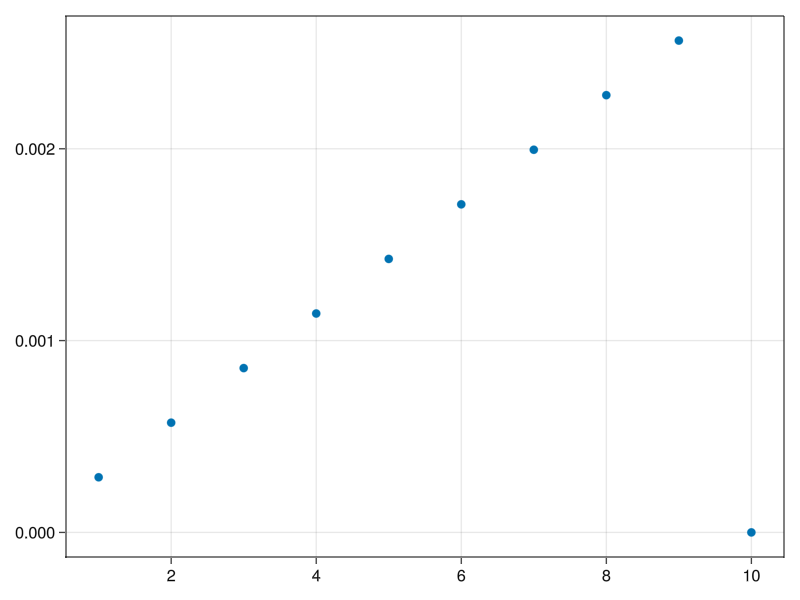

In [54]:
if test
    scatter(e)
end

In [55]:
f(μ) = (1-μ/2)/(1+μ/2) - exp(-μ)

f (generic function with 1 method)

In [56]:
lines(f)

LoadError: UndefVarError: line not defined